In [141]:
import tweepy
import pandas as pd
from pyspark.sql import functions as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from dotenv import load_dotenv
import os

In [149]:
load_dotenv()

# Initializing API client
client = tweepy.Client(consumer_key=os.getenv('TWEEPY_CONSUMER_KEY')
                     , consumer_secret=os.getenv('TWEEPY_CONSUMER_SECRET')
                     , bearer_token=os.getenv('TWEEPY_BEARER_TOKEN')
                     , access_token=os.getenv('TWEEPY_ACCESS_TOKEN')
                     , access_token_secret=os.getenv('TWEEPY_ACCESS_TOKEN_SECRET')
                     , wait_on_rate_limit=True)

In [156]:
def get_user_last_tweets(username, max_results=100):
    '''
    Returns a list of last `max_results` tweets from the handle @`username`, and the respective tweet IDs.
    '''
    userId_client_response = client.get_user(username=username)
    userId = userId_client_response.data.data['id']
    tweets = client.get_users_tweets(id = userId, exclude=['retweets', 'replies'], max_results=max_results)
    tweet_list = [[tweet.id, tweet.text] for tweet in tweets.data]
    return tweet_list

In [157]:
def get_user_likers_frequency(tweet_list):
    '''
    Takes as input a list of twit IDs, returns a dictionary ['username': `frequency`], where `frequency`  
    is the number of times the user has liked a tweet from the list
    '''
    likers_data = []
    for id, _ in tweet_list:
        like_data = client.get_liking_users(id=id)
        try:
            tweet_likers = [[entry.username, entry.id] for entry in like_data.data]
        except TypeError:
            tweet_likers = []
        # number_of_likes = like_data.meta['result_count']
        likers_data.append(tweet_likers)
    
    likers_dict = {}
    for tweet in likers_data:
        for like in tweet:
            liker_name = like[0]
            if liker_name not in likers_dict.keys():
                likers_dict[liker_name] = 1
            else:
                likers_dict[liker_name] += 1
    return likers_dict

In [167]:
tweets = get_user_last_tweets('brisssma')
likers_dict = get_user_likers_frequency(tweets)
likers_dataframe = pd.DataFrame([[name, likers_dict[name]] for name in likers_dict], columns=['Usuario', 'Likes'])

Rate limit exceeded. Sleeping for 191 seconds.


In [190]:
likers_dataframe['Likes'].mean()
likers_dataframe['Likes'].std()

4.155857700578487

<AxesSubplot: xlabel='Likes', ylabel='Proportion'>

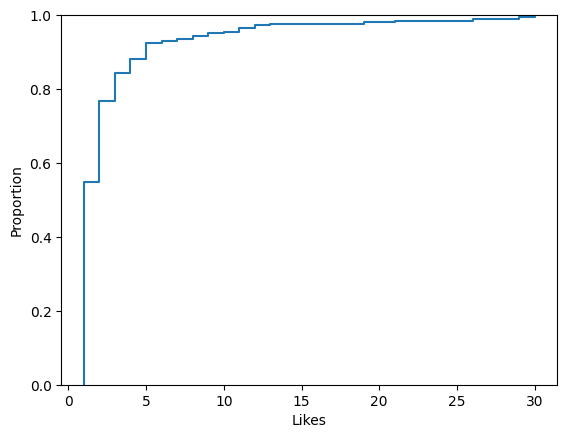

In [194]:
sns.ecdfplot(data=likers_dataframe['Likes'])

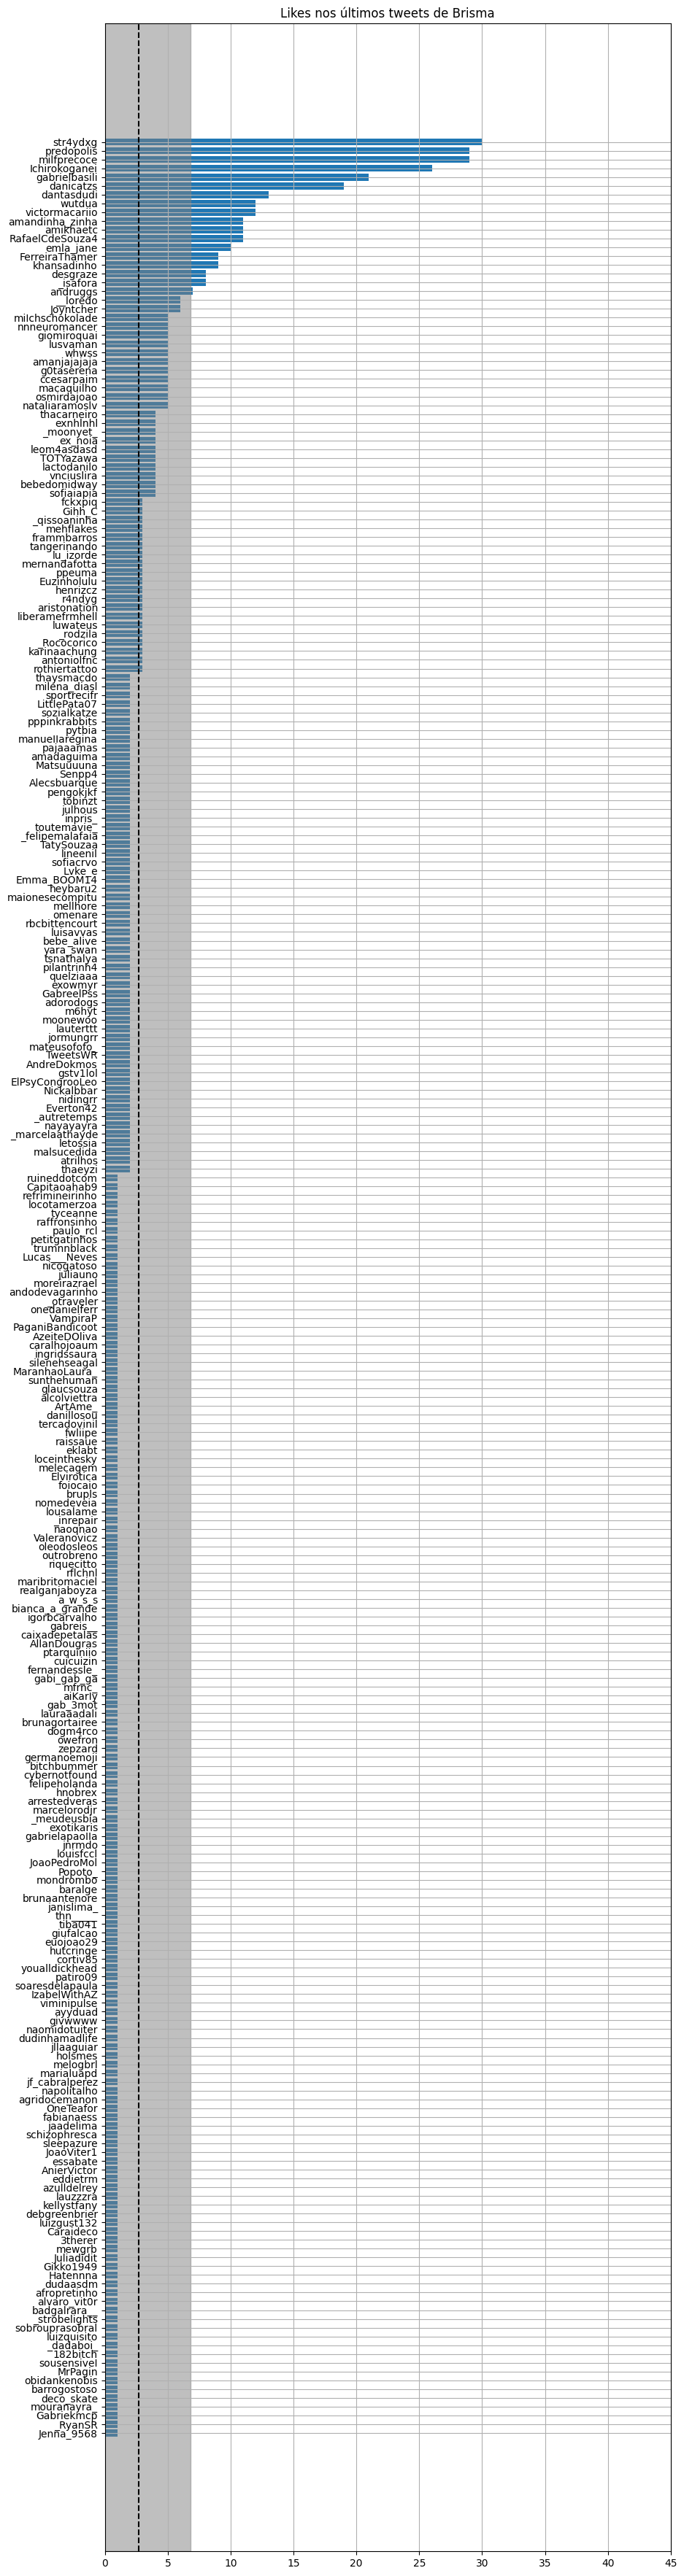

In [209]:
plt.figure(figsize=(10,45))
plt.barh('Usuario', 'Likes', data=likers_dataframe.sort_values('Likes'))
plt.axvline(likers_dataframe['Likes'].mean(), c='black', linestyle='dashed')
plt.axvspan(likers_dataframe['Likes'].mean() - likers_dataframe['Likes'].std(), likers_dataframe['Likes'].mean()+likers_dataframe['Likes'].std(), color='gray', alpha=0.5)
plt.xlim([0,45])
plt.title('Likes nos últimos tweets de Brisma')
plt.grid()
plt.savefig('brisma_likers.pdf')

22.5